In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, FastICA

from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, mean_squared_error 

from scipy.stats import kurtosis

In [6]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

In [8]:
# labels = [1]*100 + [2]*100 + [3]*100
# label_df = pd.DataFrame(labels, columns=['class'], index=df.index)
# label_df['class'] = label_df['class'].astype('category')
# label_df.to_csv('sig-label.csv')


## FUNCTIONS
- `def plot_pca_ica_sig(pca, ica, palette=pal):` plot the PCA and ICA components
- `def compute_eigens(data):` return eigenvalues and eigenvectors
- `def k_cpn_projection_on_data(eigenfunc, train, test, K=None):` return K component projection on train and test dataset, and the train mean (y_train, y_train_mean, y_test)
- `def compute_mahalanobis_distance(y_test, mean):` return mahalanobis distance between K-component-projected test data and trian mean
- `def plotly_plot(del_y, K)`: plot the distance and its mean, Q1, STD values (using plotly hence the NAME), K is the number of components projected on data
- `def get_anomaly_samples(distance, threshold):` return Series of booleans  on rows to see which row (sample) is an anomaly
- `def plot_anomalies(y, dist, thres):`  plotting anomalies-- anomaly samples are indicated by dash lines. y = data (we use K-component-projection test data here), dist = distance, thres = threshold(which we define it ourselve)
- `def plot_confusion_mat(del_y, thres, labels):` confusion matrix plot of groud truth and prediction to see if how well classify data
- `def remove_n_cpn_projection_on_data(eigenfunc, train, test, N=0):`return y_train, y_train_mean, y_test -- the data which are first-principle-component reomoved
  

# HW 1: Separate 3 Mixed Signals
- https://github.com/akcarsten/Independent_Component_Analysis ***for more understanding***
- ICA: https://towardsdatascience.com/introduction-to-ica-independent-component-analysis-b2c3c4720cd9

In [51]:
dt = pd.read_csv('./Homework1_2.csv', header=None)
dt

0          1          2          3          4          5   \
0  26.457721   6.373042  24.406436 -21.420511 -46.703654   5.891017   
1  25.779513  16.231147  27.094654 -18.071918 -34.640614  13.241859   
2 -10.221810   1.482440  -8.163424  10.198639  23.175781   1.011951   

          6          7          8          9          10        11         12  \
0 -18.012103  56.829872 -21.871273  42.978627 -29.108275 -6.698777  32.272178   
1 -13.906859  61.356120 -19.921072  46.689437 -18.512865  3.745557  41.224511   
2   8.776835 -20.302510   8.843920 -15.738883  14.801548  6.234125  -9.103315   

          13        14        15         16         17         18         19  \
0 -18.662368 -2.061580 -2.299116   5.125023 -49.228321  55.760879  11.234361   
1  -7.164441  4.708875  5.857856  16.509455 -34.177493  63.534693  14.114177   
2  11.485449  3.426512  4.564833   3.016610  25.026624 -18.381178  -3.050334   

          20         21         22         23         24         25  \
0 -14.990338 -45.536815 -35.619598 -18.388911  27.280419  37.578996   
1  -7.641113 -35.477316 -23.056885 -20.171455  30.645110  34.744877   
2   8.325784  20.994984  17.924452   5.501897  -9.677506 -15.613799   

          26        27         28         29        30         31         32  \
0  15.458865 -2.007697 -35.156316 -23.760977  3.041349 -35.442231 -10.278091   
1  18.020072 -8.015254 -42.248829 -23.943860 -6.770960 -31.683030 -19.095058   
2  -4.747062 -1.183775  11.487246   9.633151 -4.651450  15.497974   0.444301   

          33         34        35         36         37         38         39  \
0  40.431621  16.406814  0.011699  29.720167 -40.324473 -37.652082 -11.544834   
1  31.560877  14.132623 -3.989430  25.580950 -47.008981 -41.926470 -22.912507   
2 -19.223810  -7.714209 -2.461812 -13.431951  12.445531  12.798419   0.200497   

         40         41         42         43         44         45         46  \
0  5.144532 -46.710109  34.194084 -42.444250  31.805484 -39.959518  20.032946   
1  4.459488 -43.472972  26.586578 -44.745418  19.574386 -43.483768   4.934159   
2 -1.629085  19.496966 -15.315728  15.808066 -17.035246  13.799230 -14.146379   

          47         48         49         50         51         52        53  \
0  41.021058  32.050171  26.592997 -10.433834  13.435092  52.523531 -3.874719   
1  38.547264  30.705422  20.930864 -23.065422  -0.191710  44.125284 -7.176445   
2 -17.418156 -13.235058 -12.832760  -1.250880 -10.731002 -23.037597  0.715574   

          54        55         56         57         58         59  
0 -12.330504  3.633880 -47.078784  36.485556  39.828980 -44.407339  
1 -22.848881  3.151831 -44.786313  36.383408  35.933678 -49.997388  
2   0.915156 -0.903180  19.424042 -14.003091 -16.826937  14.573394

### Standardisation conducted

In [52]:
scaled_dt = StandardScaler().fit_transform(dt.T)
scaled_dt.shape

(60, 3)

### Distribution plot of our dataset -- to check whether our data is guassian (normal)?

In [17]:

"""Interpretation of kurtosis values:
- A kurtosis value close to 0 suggests a distribution similar to a normal distribution.
- Positive kurtosis indicates heavy tails (more outliers) compared to a normal distribution.
- Negative kurtosis indicates lighter tails (fewer outliers) compared to a normal distribution
"""
kurtosis_value = kurtosis(dt.T)

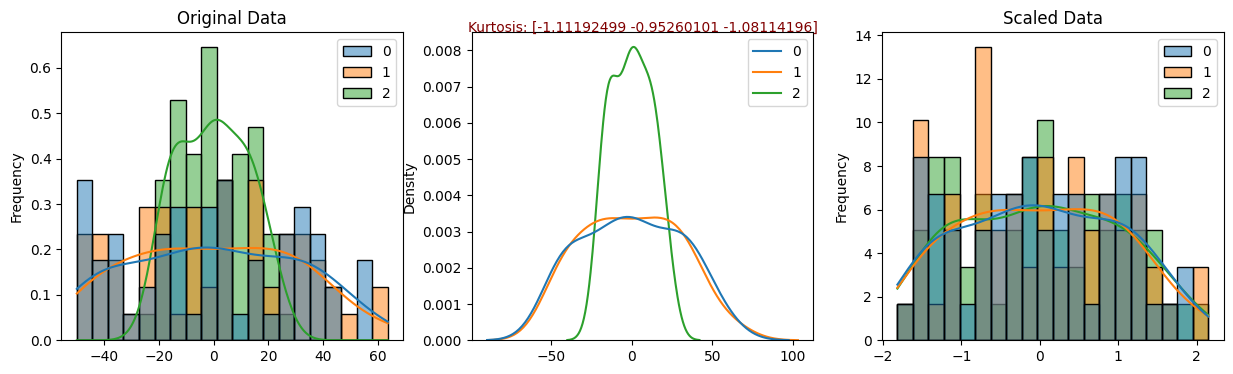

In [18]:
plt.figure(figsize=(15,4)).tight_layout()

sns.histplot(dt.T, stat='frequency', kde=True, bins=20, ax=plt.subplot(1,3,1))
plt.subplot(1,3,1).set_title('Original Data')

sns.kdeplot(dt.T, ax=plt.subplot(1,3,2))
plt.annotate(f'Kurtosis: {kurtosis_value}', xy=(0.5, 1), xycoords='axes fraction', ha='center', fontsize=10, color='maroon')


sns.histplot(scaled_dt, stat='frequency', kde=True, bins=20, ax=plt.subplot(1,3,3))
plt.subplot(1,3,3).set_title('Scaled Data')

# dt.T.plot(kind='hist', bins=20, legend=False, title='Original', ax=plt.subplot(1,3,3))

plt.show()

### conducted PCA and ICA

In [58]:
pca_m =PCA(n_components=3,random_state=42)
pca_com = pca_m.fit_transform(dt.T)


In [59]:
ica_m = FastICA(n_components=3, random_state=42)
ica_com = ica_m.fit_transform(dt.T)

In [60]:
ica_com.shape , pca_com.shape

((60, 3), (60, 3))

In [61]:
pca_com.shape[1]

3

In [62]:
#PALETTE
pal=sns.crayon_palette(sns.crayons)[8:11]

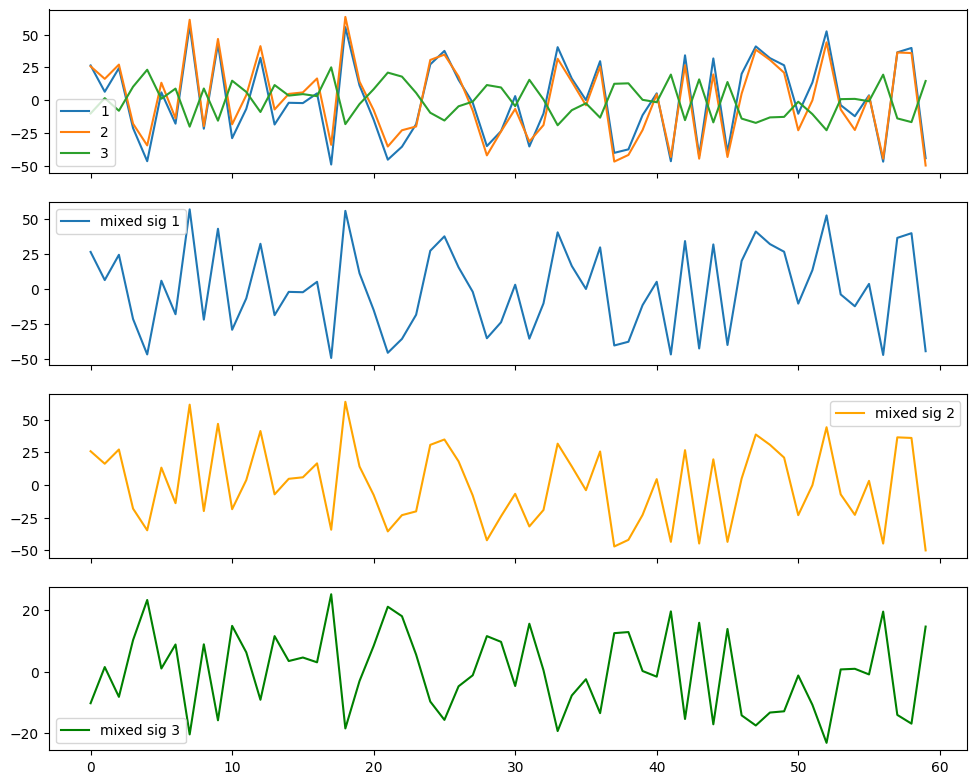

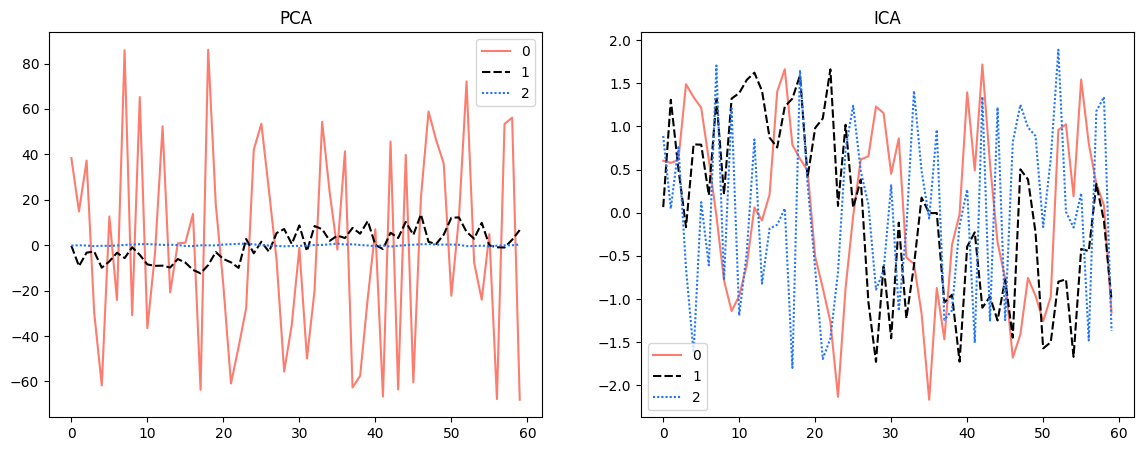

In [63]:
#ALL PLOTS COMBINED
fig, ax = plt.subplots(nrows=4,ncols=1, figsize=(10,8), sharex=True)
fig.tight_layout()
ax[0].plot(dt.T, label=(dt.index +1))
ax[0].legend()

ax[1].plot(dt.loc[0].T, label= 'mixed sig 1')
ax[2].plot(dt.loc[1].T, label= 'mixed sig 2', c='orange')
ax[3].plot(dt.loc[2].T, label= 'mixed sig 3', c='green')
ax[1].legend()
ax[2].legend()
ax[3].legend()

plt.show()

#ALL THREE TOGETHER 
plt.figure(figsize=(14,5)).tight_layout()
plt.subplot(1,2,1).set_title('PCA')
sns.lineplot(pca_com, ax=plt.subplot(1,2,1), palette=pal)

plt.subplot(1,2,2).set_title('ICA')
sns.lineplot(ica_com, ax=plt.subplot(1,2,2), palette=pal)
plt.show()

In [346]:
'''
sns.lineplot(pca_com[:,0], ax=ax[1][0])
sns.lineplot(pca_com[:,1], ax=ax[2][0])
sns.lineplot(pca_com[:,2], ax=ax[3][0])

sns.lineplot(ica_com[:,0], ax=ax[1][1])
sns.lineplot(ica_com[:,1], ax=ax[2][1])
sns.lineplot(ica_com[:,2], ax=ax[3][1])
'''
# def plot_trans_sig(com , col,ax, palette=pal):
#     for i in range(com.shape[1]):
#         sns.lineplot(com[:, i], color=pal[i], ax=ax[i][col], label=f'Component {i+1}')


'\nsns.lineplot(pca_com[:,0], ax=ax[1][0])\nsns.lineplot(pca_com[:,1], ax=ax[2][0])\nsns.lineplot(pca_com[:,2], ax=ax[3][0])\n\nsns.lineplot(ica_com[:,0], ax=ax[1][1])\nsns.lineplot(ica_com[:,1], ax=ax[2][1])\nsns.lineplot(ica_com[:,2], ax=ax[3][1])\n'

In [66]:
#RESULTS OF PCA AND ICA
def plot_pca_ica_sig(pca, ica, palette=pal):
    fig, ax = plt.subplots(3,2,sharex=True, figsize=(15,7))
    fig.tight_layout()
    ax[0][0].set_title('PCA TRANSFORMED')
    for i in range(pca.shape[1]):
        sns.lineplot(pca[:, i], color=pal[i], ax=ax[i][0], label=f'Component {i+1}')

    ax[0][1].set_title('ICA TRANSFORMED')
    for i in range(ica.shape[1]):
        sns.lineplot(ica[:, i], color=pal[i], ax=ax[i][1], label=f'Component {i+1}')

    [ax[i][j].grid() for i in range(ax.shape[0]) for j in range(ax.shape[1])]
    plt.show()


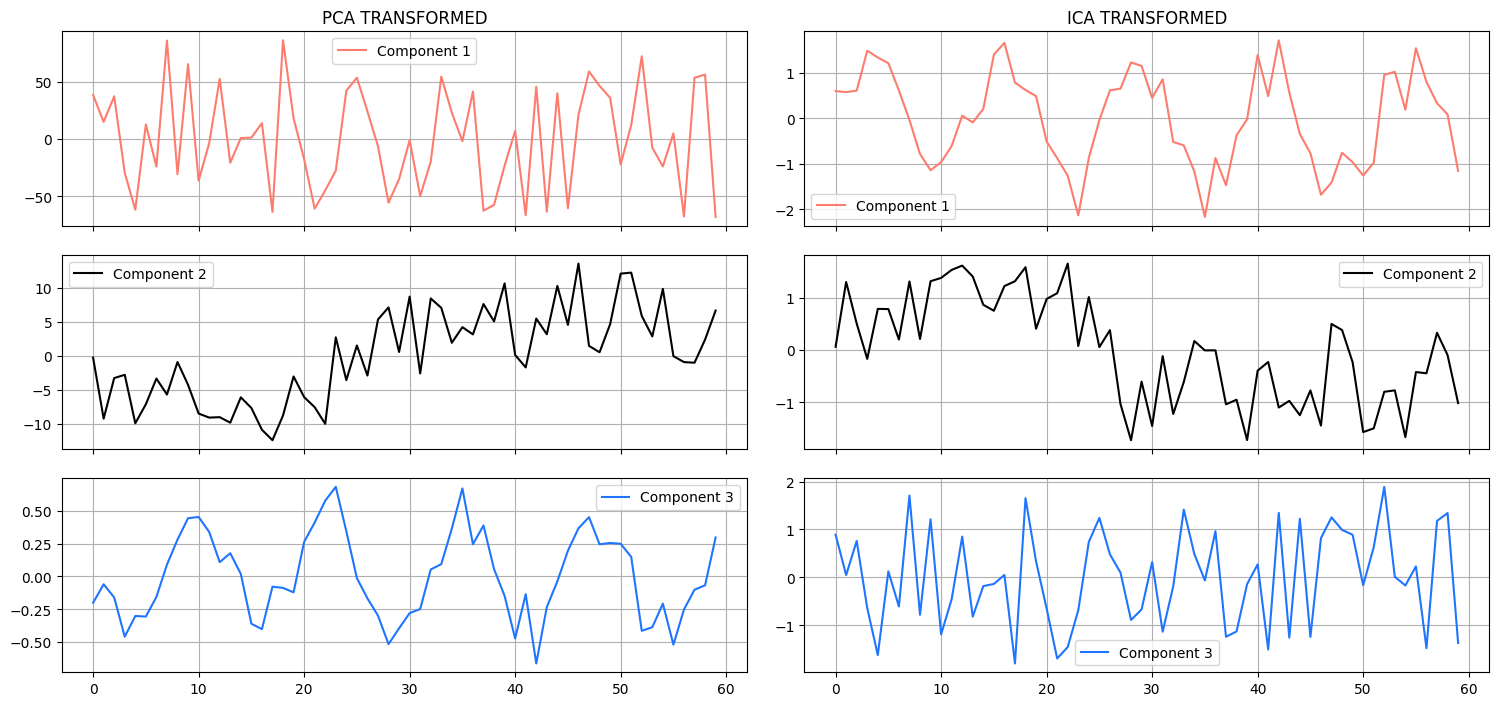

In [67]:
sns.crayon_palette(sns.crayons)

plot_pca_ica_sig(pca_com, ica_com)


# HW2 TASK 1: PCA -- Dimension reduction/ feature representation, and classification
-  1 - 100   Normal (class 1)
- 101-200  Cyclic (class 2)
- 201-300  Upward shift (class 3)

Now, we have 50 samples and 60 features on both training and test sets. => dimension = (50,60)

In [7]:
df = pd.read_csv('./Homework1_1.csv', header=None)
# class_df = pd.read_csv('./synth-sig-w-class.csv').drop(columns='Unnamed: 0')


In [8]:
train = df[:50] #first 50 of normal signal data as TRAINING
test = df[50:]# another rest of normal data -- 50 data as TEST SET 
print(train.shape, test.shape)

(50, 60) (250, 60)


## ANOMALY DETECTION
***for reference and more understanding*** : https://github.com/jeffprosise/Machine-Learning/blob/master/Anomaly%20Detection%20(PCA).ipynb 
- either follow this the code above or,
- follow your professor guide -- they both work the same way, just that your prof.'s way is to compute it by hand.



### PCA BY HAND

(60, 50)

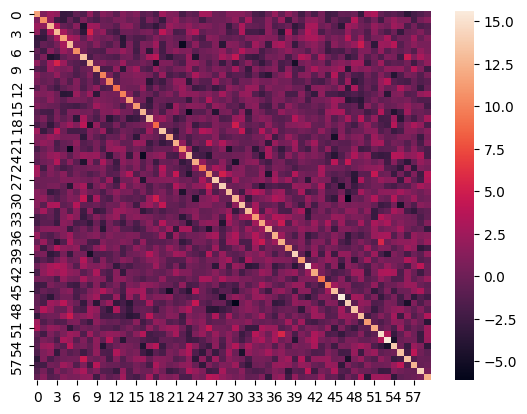

In [9]:
# sns.heatmap(np.cov(train.T))
sns.heatmap(train.cov())
train.T.shape

$y_x = E_{C} * x$

In [10]:
print(train.cov().shape)
def compute_eigens(data):
    eigenvalues, eigenvectors = np.linalg.eig(data.cov())
    #Get indices for sorting in descending order
    idx = eigenvalues.argsort()[::-1]
    #Sort the eigenvalues in descending order 
    eigenvalues = eigenvalues[idx]
    #Sort the corresponding eigenvectors accordingly
    eigenvectors = eigenvectors[:,idx]
    return eigenvalues, eigenvectors

eigenvalues, eigenvectors = compute_eigens(train)

print(eigenvalues.shape, eigenvectors.real[:10,:10].shape)

(60, 60)
(60,) (10, 10)


#### compute distance look here: https://www.geeksforgeeks.org/how-to-calculate-mahalanobis-distance-in-python/

In [686]:
# K = 10 
def k_cpn_projection_on_data(eigenfunc, train, test, K=None):# FUNCTION FOR COMPUTING K COMPONENTS PROJECTION ONTO DATA
    eigenvals, eigenvectors = eigenfunc(train)
    if K==None:
        K=train.shape[1]
    y_train = eigenvectors.real[:K,:] @ train.T
    y_train_mean = np.mean(y_train, axis=1)
    y_test = eigenvectors.real[:K,:] @ test.T
    return y_train, y_train_mean, y_test

def euclidean_distance(y_test, mean):
    dist = np.sqrt(np.sum((y_test.T - mean)**2, axis=1))
    return dist
    
def compute_mahalanobis_distance(y_test, mean):
    cov = y_test.T.cov()
    centred_y_test = y_test.T - mean
    inv_cov = np.linalg.inv(cov)
    mdist =np.dot(np.dot(centred_y_test, inv_cov ), centred_y_test.T)
    return pd.Series(mdist.diagonal(), index=y_test.T.index)

In [688]:
# cen = y_test_10.T  - train_10_mean
# cov = y_test_10.T.cov()
# inv_cov = pd.DataFrame(np.linalg.inv(cov))
# print(cen.T.shape, cov.shape, inv_cov.shape, cen.shape)
# m =(np.dot(np.dot(cen, inv_cov ), cen.T))
# m.diagonal()


In [21]:
y_train_5, train_5_mean, y_test_5 = k_cpn_projection_on_data(compute_eigens, train, test, 5)
y_train_10,  train_10_mean, y_test_10 = k_cpn_projection_on_data(compute_eigens, train,test, 10)
y_train_30,  train_30_mean, y_test_30 = k_cpn_projection_on_data(compute_eigens, train,test, 30)
print(y_train_10.shape,  train_10_mean.shape, y_test_10.shape)


del_y_5 = compute_mahalanobis_distance(y_test_5, train_5_mean)
del_y_10 = compute_mahalanobis_distance(y_test_10, train_10_mean)
del_y_30 = compute_mahalanobis_distance(y_test_30, train_30_mean)

(10, 50) (10,) (10, 250)


In [22]:
def reconstruct_data(data, feat_vec):
    reconstructed = data @ feat_vec
    return reconstructed

In [678]:
def plotly_plot(del_y, K=None):
    if not K:
        title='The Error plot'
    else:
        title = f'distance of y_x and mean_vec when K = {K}'
        
    fig = px.line(del_y, title=title).add_hline( 
            y=np.mean(del_y), 
            line_color='black', 
            line_width=2, 
            line_dash ='dash',
            annotation_text = 'mean'
        ).add_hline( 
        y=np.quantile(del_y,0.25), 
        line_color='red', 
        line_width=2, 
        line_dash ='dash',
        annotation_text = '1st quantile'
        ).add_hline( 
        y=np.std(del_y), 
        line_color='orange', 
        line_width=2, 
        line_dash ='dash',
        annotation_text = 'std')
    return fig

    

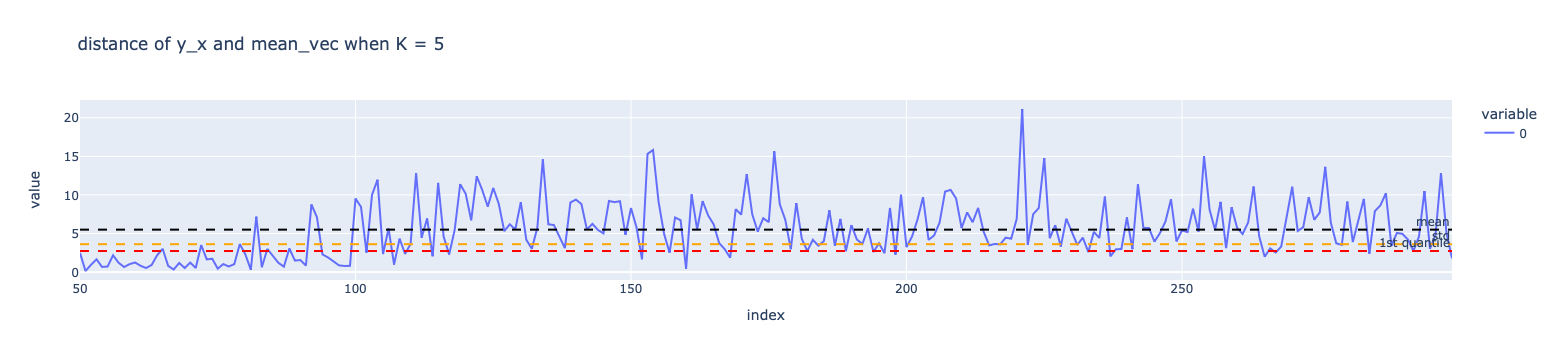

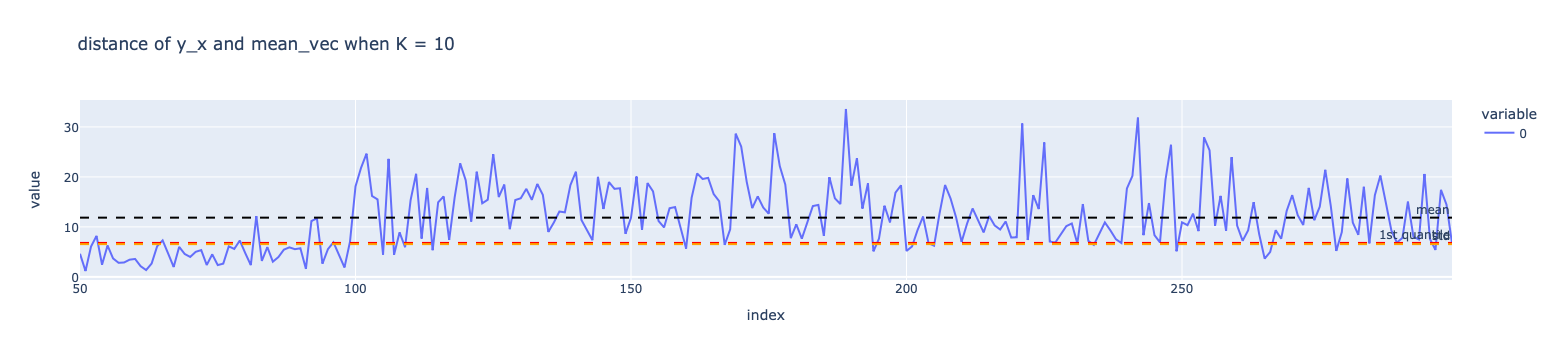

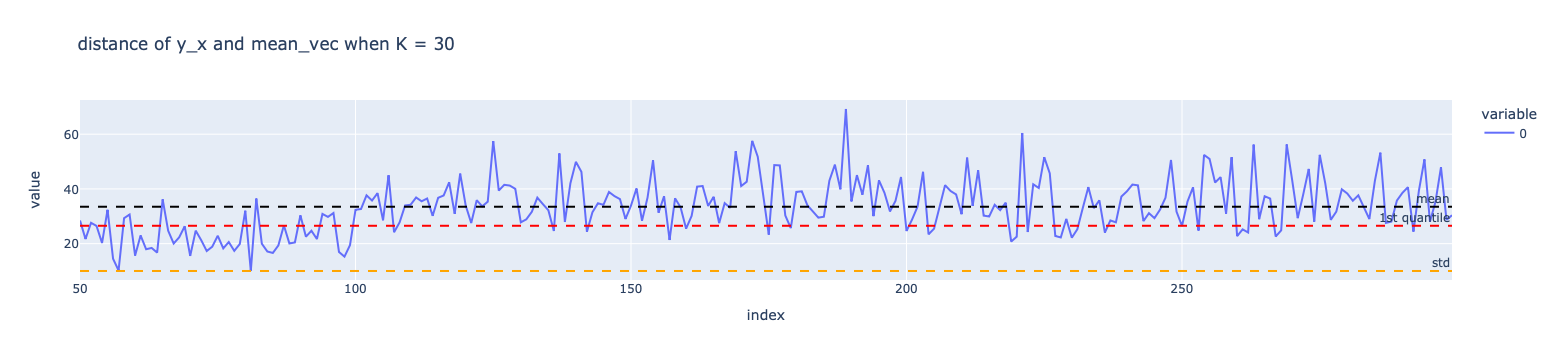

In [679]:
plotly_plot(del_y_5, 5).show()
plotly_plot(del_y_10,10).show()
plotly_plot(del_y_30,30).show()

### DEFINE THRESHOLD AND DETECT ANOMALIES

anomaly sample:Index([ 79,  82,  92,  93, 100, 101, 103, 104, 106, 108,
       ...
       286, 287, 289, 290, 291, 293, 294, 296, 297, 298],
      dtype='int64', length=161)


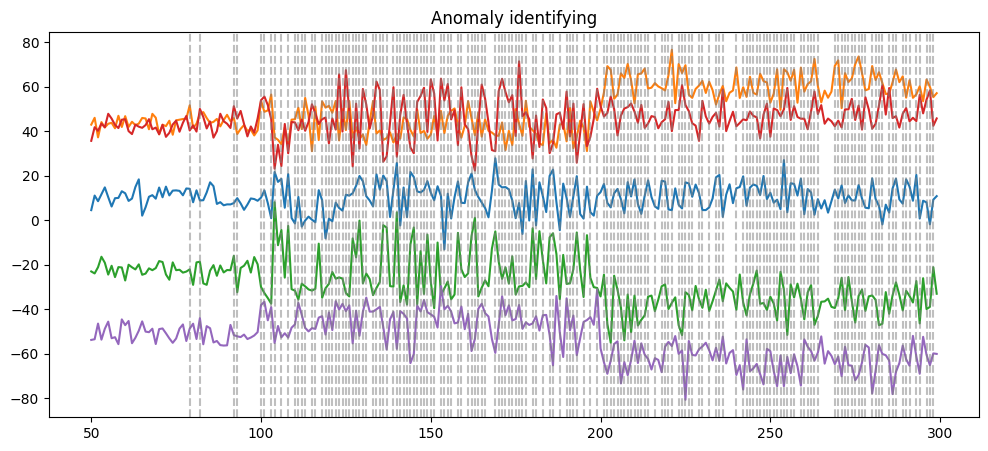

anomaly sample:Index([ 53,  65,  79,  82,  92,  93,  96,  99, 100, 101,
       ...
       288, 289, 290, 291, 292, 293, 294, 295, 297, 298],
      dtype='int64', length=187)


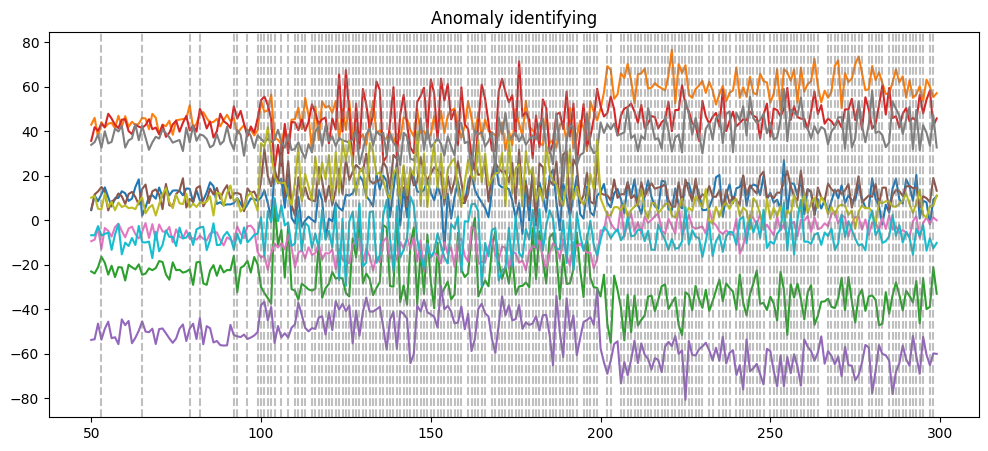

anomaly sample:Index([ 50,  52,  55,  58,  59,  65,  80,  82,  87,  90,
       ...
       289, 290, 291, 293, 294, 295, 296, 297, 298, 299],
      dtype='int64', length=187)


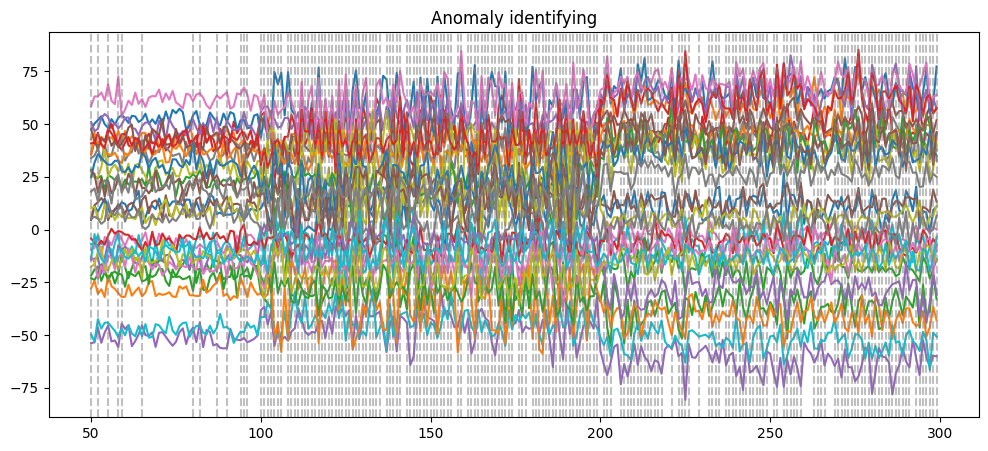

In [680]:
def get_anomaly_samples(distance, threshold):
    return pd.Series(distance > threshold)
    
def plot_anomalies(y, dist, thres):
    anomaly_row = pd.Series(dist > thres)
    
    y.T.plot(figsize=(12,5), title='Anomaly identifying')
    anomalies = y.T.loc[anomaly_row]
    print(f'anomaly sample:{anomalies.index}')
    
    for i in anomalies.index:
        plt.axvline(i, color='grey', ls='--', alpha=0.5)
    plt.legend().remove()
    plt.show()
    
plot_anomalies(y_test_5, del_y_5, np.std(del_y_5))
plot_anomalies(y_test_10, del_y_10, np.quantile(del_y_10, 0.25))
plot_anomalies(y_test_30, del_y_30, np.quantile(del_y_30, 0.25))


In [34]:
new_labels = [False]*50 + [True]*200

In [706]:
def plot_confusion_mat(del_y, thres, labels):
    predict = get_anomaly_samples(del_y, thres)
    con = confusion_matrix(labels, predict, normalize='true')
    sns.heatmap(con, fmt='.2%',annot=True, cbar=False, xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
    plt.xlabel('Prediction')
    plt.ylabel('Ground Truth')
    plt.show()


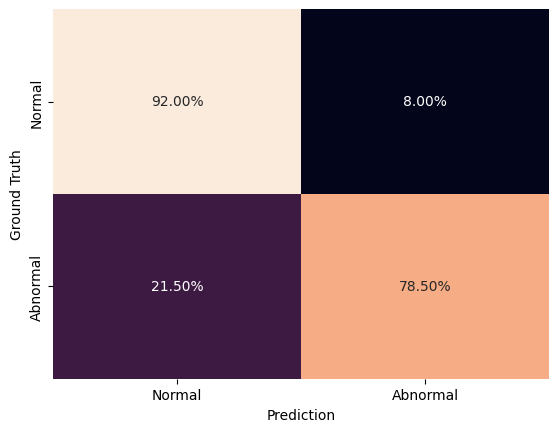

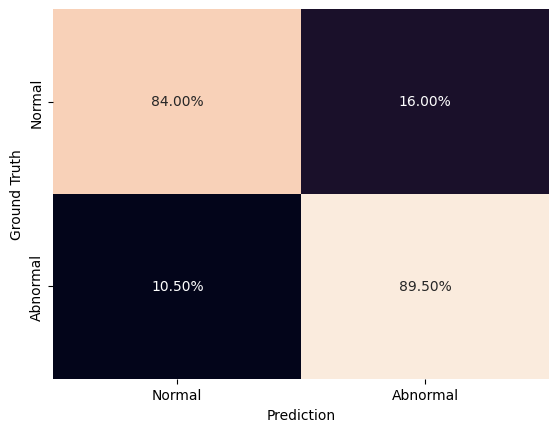

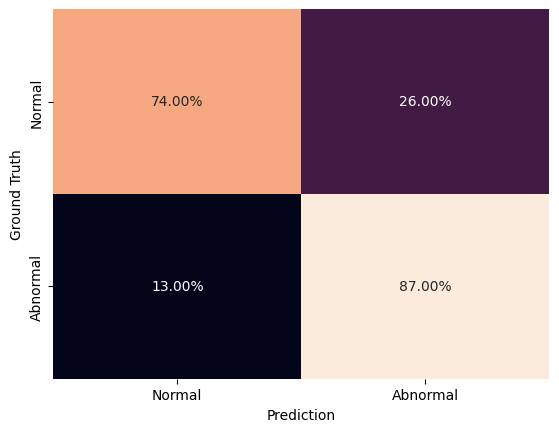

In [707]:
"""
By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
is equal to the number of observations known to be in group :math:`i` and
predicted to be in group :math:`j`.

Thus in binary classification, 
the count of true negatives is:math:`C_{0,0}`, 
false negatives is :math:`C_{1,0}`, 
true positives is:math:`C_{1,1}` and 
false positives is :math:`C_{0,1}`.
"""
# np.quantile(del_y_5, 0.25)
plot_confusion_mat(del_y_5, del_y_5.std(), new_labels) #use STD as a threshold
plot_confusion_mat(del_y_10, np.quantile(del_y_10, 0.25), new_labels)
plot_confusion_mat(del_y_30, np.quantile(del_y_30, 0.25), new_labels)



***HW instruction*** (compute by hand)
- let $y^-_normal$  be the mean vector of normal training samples. The anomaly is detected as follows:
Compute the distance for a test sample: 
- Compute the distance  delta $y_x = abs(y_x - y^-_normal)$ for a test sample x  


## A) Remove first component
*for more understanding:* https://machinelearningmastery.com/principal-component-analysis-for-visualization/
- X - 1st PC -- as thogh the first component as u know it captures the most variation of data, i.e. it contains the feature that hv the most info. about the data. Doing this to see and compare how the model will perform with and without it.
- X = training set

In [36]:
def remove_n_cpn_projection_on_data(eigenfunc, train, test, N=0):# FUNCTION FOR COMPUTING K COMPONENTS PROJECTION ONTO DATA
    _, eigenvectors = eigenfunc(train)
    y_train = eigenvectors.real[N:,:] @ train.T 
    y_train_mean = np.mean(y_train, axis=1)
    y_test = eigenvectors.real[N:,:] @ test.T 
    return y_train, y_train_mean, y_test
#------------------------------------------------------------------#   
y_removed, mean_removed_y, y_test_rm = remove_n_cpn_projection_on_data(compute_eigens,train,test,1 )

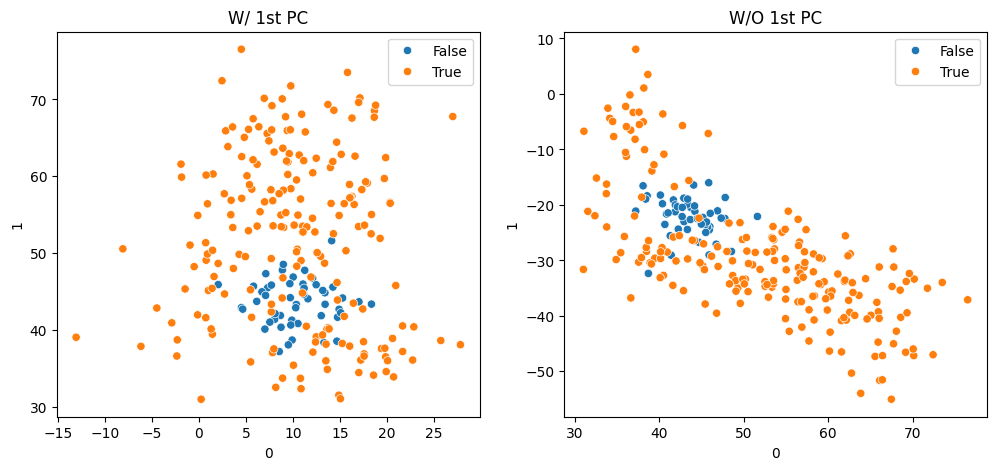

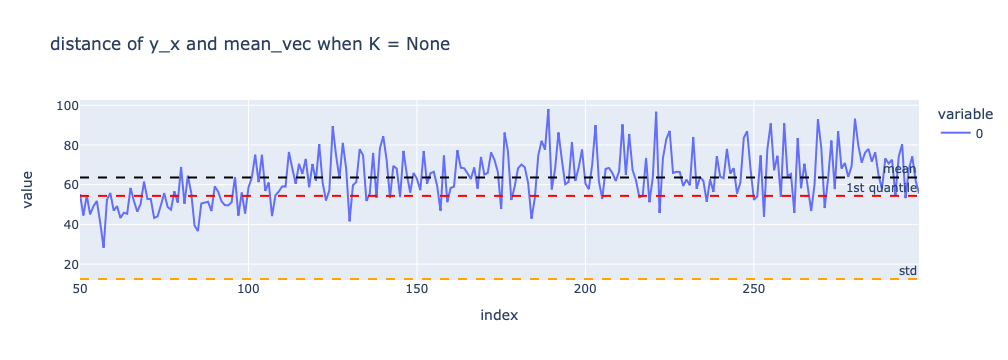

anomaly sample:Index([ 50,  52,  59,  65,  69,  75,  78,  80,  82,  83,
       ...
       289, 290, 291, 292, 293, 294, 296, 297, 298, 299],
      dtype='int64', length=187)


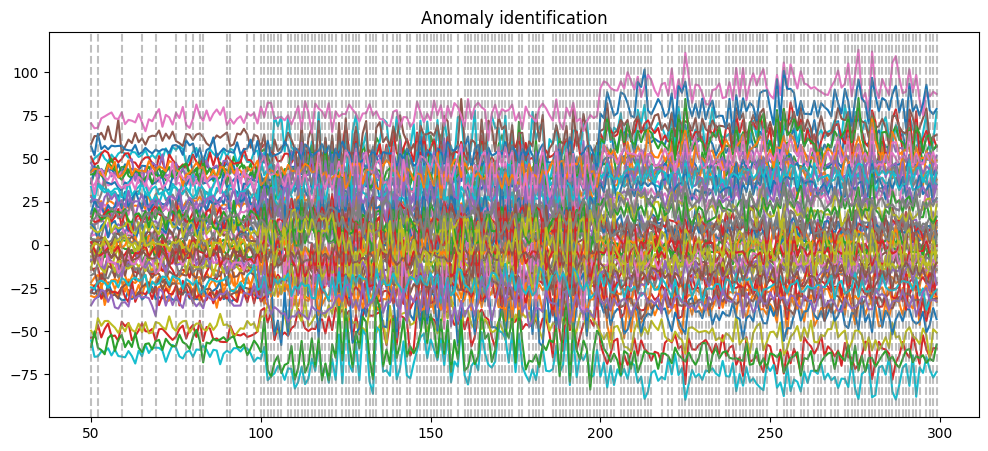

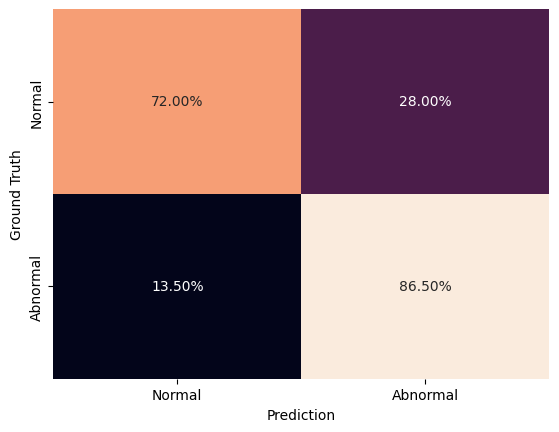

In [42]:
pca_train, mean_pca_train, pca_test = k_cpn_projection_on_data(compute_eigens, train, test)
del_y_removed = compute_mahalanobis_distance(y_test_rm, mean_removed_y)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1).set_title('W/ 1st PC')
sns.scatterplot(x=pca_test.T.iloc[:,0],y=pca_test.T.iloc[:, 1], data=pca_test.T, hue=new_labels, ax=plt.subplot(1,2,1))
plt.subplot(1,2,2).set_title('W/O 1st PC')
sns.scatterplot(x=y_test_rm.T.iloc[:,0],y=y_test_rm.T.iloc[:,1], data=y_test_rm.T, hue=new_labels, ax=plt.subplot(1,2,2))
plt.show()

pd.DataFrame(del_y_removed).T

plotly_plot(del_y_removed, None).show()
plot_anomalies(y_test_rm,del_y_removed, del_y_removed.quantile(0.25)) # Q1 OF DISTANCE AS A THRESHOLD
plot_confusion_mat(del_y_removed, del_y_removed.quantile(0.25), new_labels)
# 

## B) DATA NORMALISATION

In [43]:
standardised_data = pd.DataFrame(StandardScaler().fit_transform(df))
scaled_train = standardised_data[:50]
scaled_test = standardised_data[50:]
print(scaled_train.shape, scaled_test.shape)

(50, 60) (250, 60)


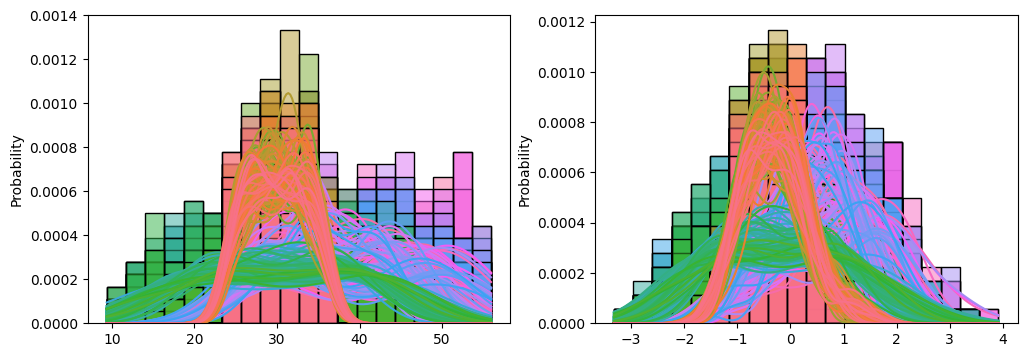

In [44]:
plt.figure(figsize=(12,4))
sns.histplot(df.T, bins=20, ax=plt.subplot(1,2,1), kde=True, legend=False, stat='probability')
sns.histplot(standardised_data.T, bins=20, ax=plt.subplot(1,2,2), kde=True, legend=False,stat='probability' )
# df.plot(kind='hist',bins=20, ax=plt.subplot(1,2,1), title='original').legend().remove()
# standardised_data.plot(kind='hist', bins=20, ax=plt.subplot(1,2,2), title='Normalised').legend().remove()
plt.show()

In [45]:
scaled_y_train_5, scaled_train_5_mean, scaled_y_test_5 = k_cpn_projection_on_data(compute_eigens, scaled_train, scaled_test, 5)
scaled_y_train_10,  scaled_train_10_mean, scaled_y_test_10 = k_cpn_projection_on_data(compute_eigens, scaled_train, scaled_test, 10)
scaled_y_train_30,  scaled_train_30_mean, scaled_y_test_30 = k_cpn_projection_on_data(compute_eigens, scaled_train, scaled_test, 30)
print(scaled_y_train_10.shape,  scaled_train_10_mean.shape, scaled_y_test_10.shape)

del_scaled_y_5 = compute_mahalanobis_distance(scaled_y_test_5, scaled_train_5_mean)
del_scaled_y_10 = compute_mahalanobis_distance(scaled_y_test_10, scaled_train_10_mean)
del_scaled_y_30 = compute_mahalanobis_distance(scaled_y_test_30, scaled_train_30_mean)

scaled_y_train, scaled_train_mean, scaled_y_test = k_cpn_projection_on_data(compute_eigens, scaled_train,  scaled_test,)
del_scaled_y = compute_mahalanobis_distance(scaled_y_test, scaled_train_mean)

(10, 50) (10,) (10, 250)


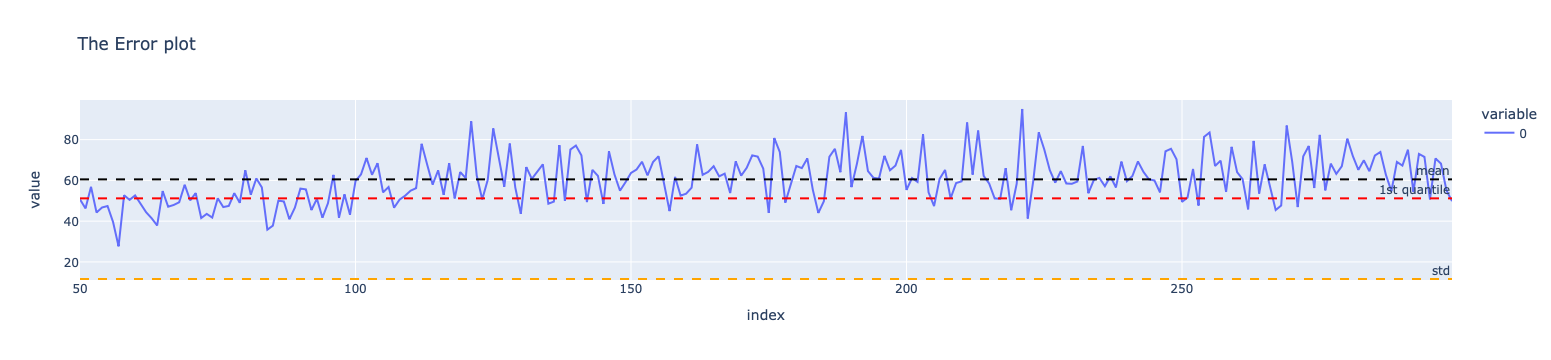

In [708]:
plotly_plot(del_scaled_y, None).show()

anomaly sample:Index([ 80,  82,  96, 101, 102, 103, 104, 112, 113, 115,
       ...
       285, 286, 287, 289, 290, 291, 293, 294, 296, 297],
      dtype='int64', length=124)


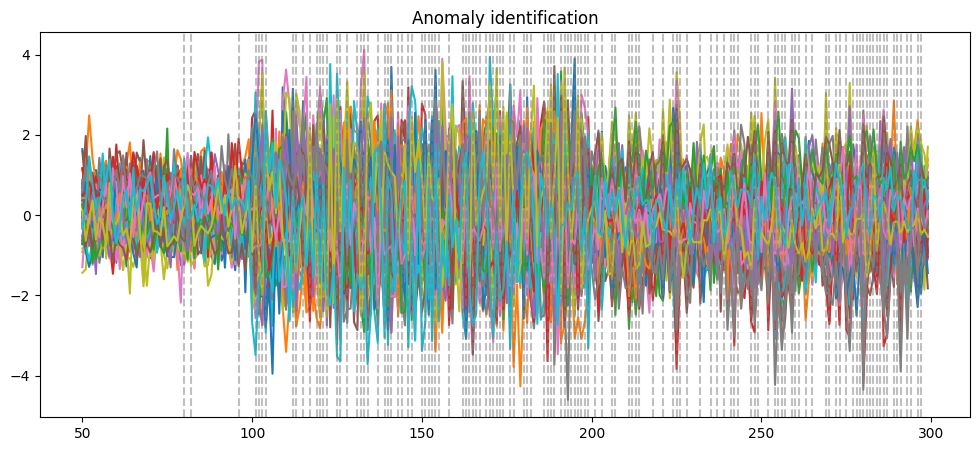

In [47]:
th = del_scaled_y.mean() #Threshold

plot_anomalies(scaled_y_test, del_scaled_y,th ) ## threshold here is mean of distance

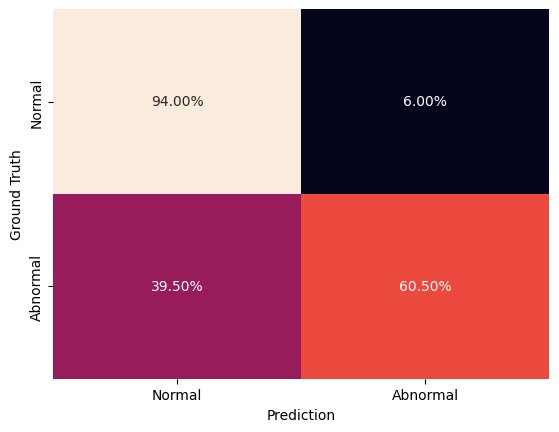

In [48]:
plot_confusion_mat(del_scaled_y, th, new_labels) #Q1 of distance as a threshold

## C) SMOOTHING:
For the signal separation task, apply smoothing (e.g. moving average or low-pass filtering) to reduce of noise in the time-series data, and observe the separated signals with PCA, and the anomaly detection result.

- https://learnpython.com/blog/python-moving-average/
- https://www.geeksforgeeks.org/how-to-calculate-moving-average-in-a-pandas-dataframe/
- https://www.linkedin.com/pulse/mastering-low-pass-high-pass-filters-image-processing-allan-cruz-2nlzf
- https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units

In [49]:
from scipy.signal import butter, lfilter, filtfilt, freqz

## SIGNAL SEPARATION TASK
- #### MOVING AVERAGE

In [53]:
dt

0          1          2          3          4          5   \
0  26.457721   6.373042  24.406436 -21.420511 -46.703654   5.891017   
1  25.779513  16.231147  27.094654 -18.071918 -34.640614  13.241859   
2 -10.221810   1.482440  -8.163424  10.198639  23.175781   1.011951   

          6          7          8          9          10        11         12  \
0 -18.012103  56.829872 -21.871273  42.978627 -29.108275 -6.698777  32.272178   
1 -13.906859  61.356120 -19.921072  46.689437 -18.512865  3.745557  41.224511   
2   8.776835 -20.302510   8.843920 -15.738883  14.801548  6.234125  -9.103315   

          13        14        15         16         17         18         19  \
0 -18.662368 -2.061580 -2.299116   5.125023 -49.228321  55.760879  11.234361   
1  -7.164441  4.708875  5.857856  16.509455 -34.177493  63.534693  14.114177   
2  11.485449  3.426512  4.564833   3.016610  25.026624 -18.381178  -3.050334   

          20         21         22         23         24         25  \
0 -14.990338 -45.536815 -35.619598 -18.388911  27.280419  37.578996   
1  -7.641113 -35.477316 -23.056885 -20.171455  30.645110  34.744877   
2   8.325784  20.994984  17.924452   5.501897  -9.677506 -15.613799   

          26        27         28         29        30         31         32  \
0  15.458865 -2.007697 -35.156316 -23.760977  3.041349 -35.442231 -10.278091   
1  18.020072 -8.015254 -42.248829 -23.943860 -6.770960 -31.683030 -19.095058   
2  -4.747062 -1.183775  11.487246   9.633151 -4.651450  15.497974   0.444301   

          33         34        35         36         37         38         39  \
0  40.431621  16.406814  0.011699  29.720167 -40.324473 -37.652082 -11.544834   
1  31.560877  14.132623 -3.989430  25.580950 -47.008981 -41.926470 -22.912507   
2 -19.223810  -7.714209 -2.461812 -13.431951  12.445531  12.798419   0.200497   

         40         41         42         43         44         45         46  \
0  5.144532 -46.710109  34.194084 -42.444250  31.805484 -39.959518  20.032946   
1  4.459488 -43.472972  26.586578 -44.745418  19.574386 -43.483768   4.934159   
2 -1.629085  19.496966 -15.315728  15.808066 -17.035246  13.799230 -14.146379   

          47         48         49         50         51         52        53  \
0  41.021058  32.050171  26.592997 -10.433834  13.435092  52.523531 -3.874719   
1  38.547264  30.705422  20.930864 -23.065422  -0.191710  44.125284 -7.176445   
2 -17.418156 -13.235058 -12.832760  -1.250880 -10.731002 -23.037597  0.715574   

          54        55         56         57         58         59  
0 -12.330504  3.633880 -47.078784  36.485556  39.828980 -44.407339  
1 -22.848881  3.151831 -44.786313  36.383408  35.933678 -49.997388  
2   0.915156 -0.903180  19.424042 -14.003091 -16.826937  14.573394

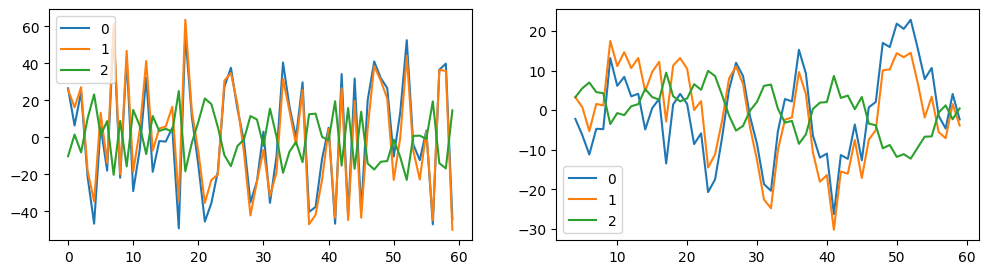

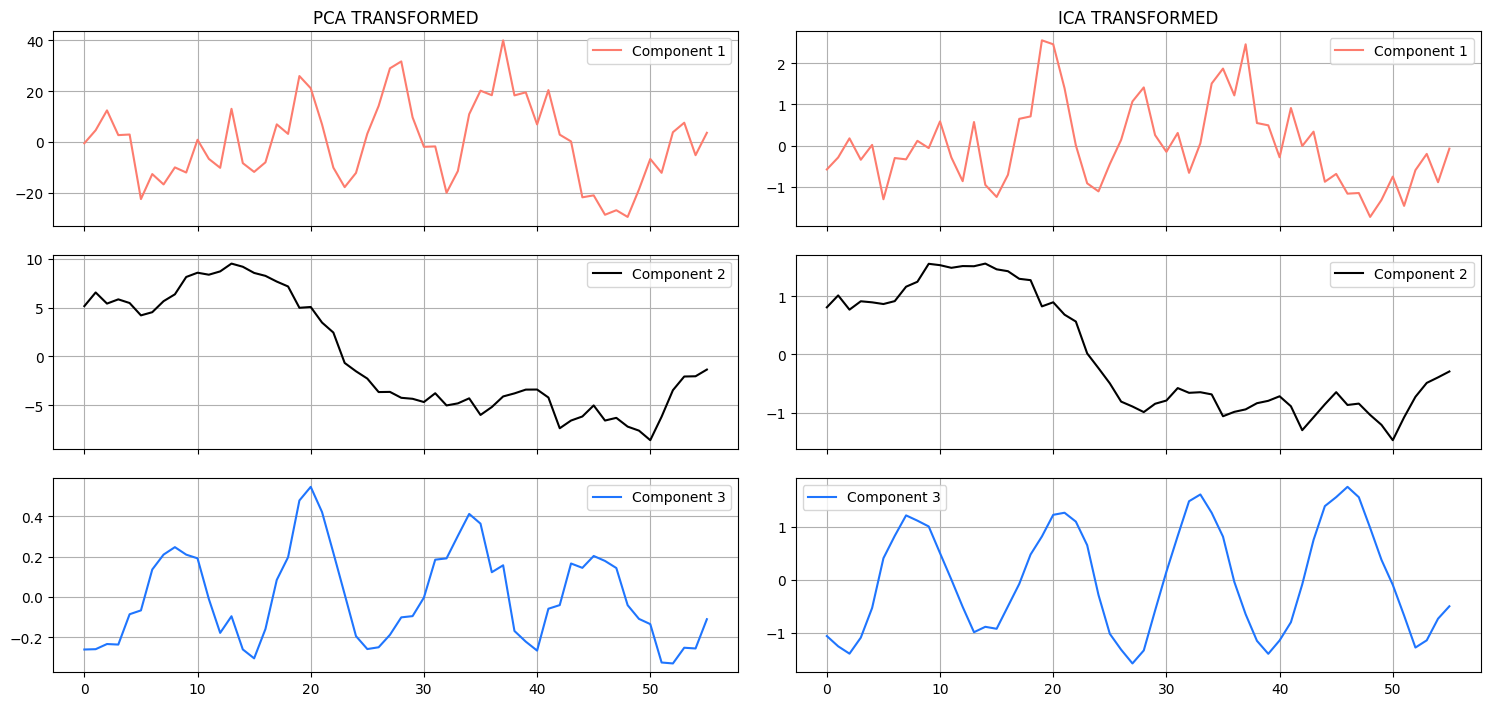

In [71]:
dt.T.plot(ax = plt.subplot(1,2,1), figsize=(12,3))
mv_avg_dt  = dt.T.rolling(5).mean().dropna()
mv_avg_dt.plot(ax=plt.subplot(1,2,2)).legend()


smooth_pca = PCA(n_components=3, random_state=42).fit_transform(mv_avg_dt)
smooth_ica = FastICA(n_components=3, random_state=42).fit_transform(mv_avg_dt)

plot_pca_ica_sig(smooth_pca, smooth_ica)

#### Applied LOW-PASS FILTERING

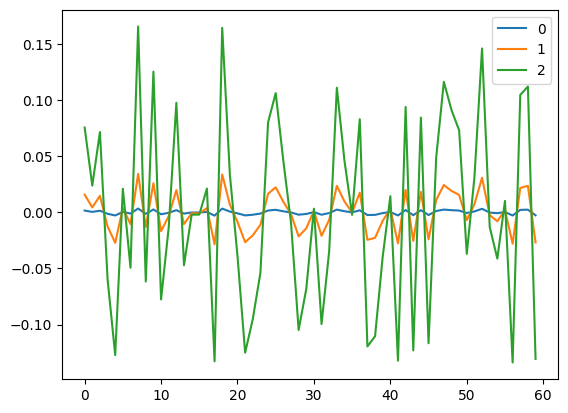

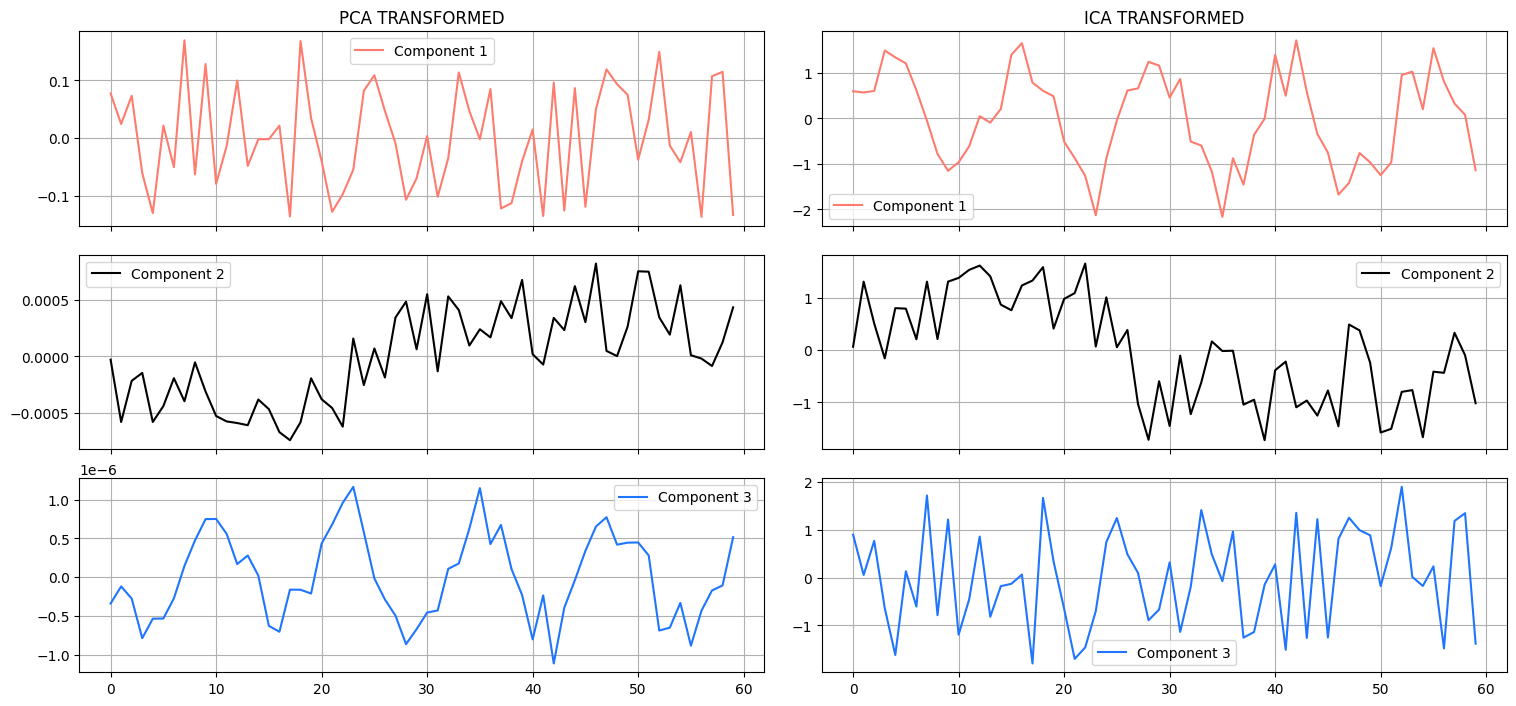

In [72]:
b, a =  butter(5, 0.1)
low_filtered = lfilter(b, a, dt.T)
low_filtered_dt = pd.DataFrame(low_filtered)
low_filtered_dt.plot()

pca_lf =  PCA(n_components=3, random_state=42).fit_transform(low_filtered_dt)
ica_lf = FastICA(n_components=3, random_state=42).fit_transform(low_filtered_dt)

plot_pca_ica_sig(pca_lf, ica_lf)

### Anmaly detection

0          1          2          3          4          5   \
50   1.273113   7.764738  20.494123  30.980169  31.200833  26.717153   
51   1.317992   8.423047  23.246483  36.383532  36.445437  27.782866   
52   1.325921   7.999621  21.026570  32.235857  33.850815  29.515370   
53   1.657308   9.821438  24.827668  35.222564  32.549402  25.660002   
54   1.373951   8.271482  21.575640  32.850891  34.969457  32.150920   
..        ...        ...        ...        ...        ...        ...   
295  1.594313   9.547018  24.151165  33.758964  30.410018  24.485738   
296  1.443175   8.531750  21.471614  30.450233  28.901534  24.742729   
297  1.895718  11.054524  27.391192  38.082362  34.748490  27.087031   
298  1.831630  10.509968  25.631074  35.226457  32.256474  26.220181   
299  1.503747   9.321699  24.612576  36.601856  36.239801  31.625150   

            6          7          8          9          10         11  \
50   27.156556  30.866645  30.906848  27.993850  27.072346  28.599358   
51   23.811034  26.692469  28.557726  27.764320  28.312290  29.164582   
52   26.967596  28.494675  31.893255  33.498068  31.844934  28.949725   
53   25.432849  29.485663  31.427182  30.724572  29.852841  30.125939   
54   30.496174  30.746341  32.316770  33.112240  30.330228  26.980775   
..         ...        ...        ...        ...        ...        ...   
295  26.373224  31.036572  32.177674  31.713895  31.852491  31.310798   
296  25.997901  29.863865  32.126055  33.067691  33.681269  33.157468   
297  25.365054  27.442728  29.370472  31.456591  33.386405  33.578020   
298  26.282613  28.973938  29.334649  29.603875  31.416447  31.372391   
299  32.181696  33.425897  30.300197  26.854100  27.536905  30.662226   

            12         13         14         15         16         17  \
50   30.556974  31.837645  31.723446  31.225418  31.842221  32.173276   
51   28.921530  29.860073  30.075300  27.456487  26.785296  29.593945   
52   26.719041  27.059290  30.734357  32.730668  29.511172  26.319324   
53   30.958300  31.155688  31.001240  32.018894  33.806022  33.403502   
54   28.748644  33.968636  36.107051  33.930858  31.926212  32.881985   
..         ...        ...        ...        ...        ...        ...   
295  29.418482  28.551922  30.364410  32.031036  31.423718  30.531931   
296  30.532833  28.064652  28.654627  31.005969  32.804154  33.480929   
297  31.989459  30.206162  29.616252  29.967322  30.977438  32.861091   
298  29.289472  29.493853  32.247389  33.383724  32.203793  32.548563   
299  31.291816  28.380149  27.421535  31.908053  36.325747  34.262797   

            18         19         20         21         22         23  \
50   30.556039  29.097652  29.954395  30.572484  28.845114  27.226409   
51   30.201531  28.225190  29.467838  32.973733  32.685423  30.187599   
52   26.922001  28.040435  28.283701  29.479166  30.735221  30.699915   
53   29.996273  26.900608  27.047709  29.782833  32.182856  32.318659   
54   34.160116  31.922975  28.059427  28.116344  30.866607  29.565026   
..         ...        ...        ...        ...        ...        ...   
295  29.310703  26.546576  26.024561  29.961920  32.770783  30.771744   
296  32.880686  32.039636  31.333107  29.689487  29.024956  31.432330   
297  32.841048  28.517426  25.192828  28.952816  35.341229  36.330674   
298  34.413917  32.353026  26.430984  24.342955  27.824350  30.374999   
299  28.390495  26.038188  28.896975  32.130538  31.896399  29.471003   

            24         25         26         27         28         29  \
50   26.963012  26.915717  27.183149  27.778223  29.032718  31.620674   
51   30.539522  31.567854  29.706754  26.992536  26.091640  26.557695   
52   31.257013  33.076887  33.399579  31.056723  28.256522  27.937322   
53   30.860758  28.721770  26.870653  28.346455  32.916715  33.883179   
54   25.717789  27.219683  32.737145  34.328117  32.073609  31.626452   
..         ...        ...        ...        ...        ...        ...   
295 

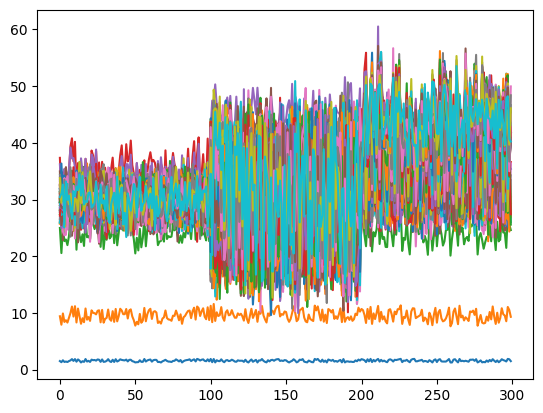

In [73]:
b, a =  butter(5, 0.5)
low_filt = lfilter(b, a, df)
low_filt_df = pd.DataFrame(low_filt)
low_filt_df.plot().legend().remove()

lf_train = low_filt_df[:50]
lf_test = low_filt_df[50:]
lf_test

(5, 50) (5, 250)


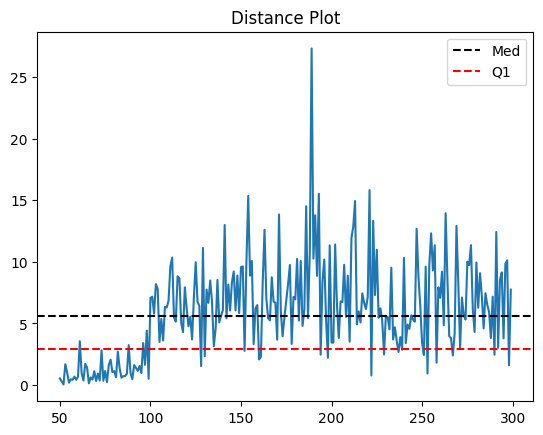

anomaly sample:Index([ 61,  88,  96,  98, 100, 101, 102, 103, 104, 105,
       ...
       288, 289, 291, 292, 293, 294, 295, 296, 297, 299],
      dtype='int64', length=187)


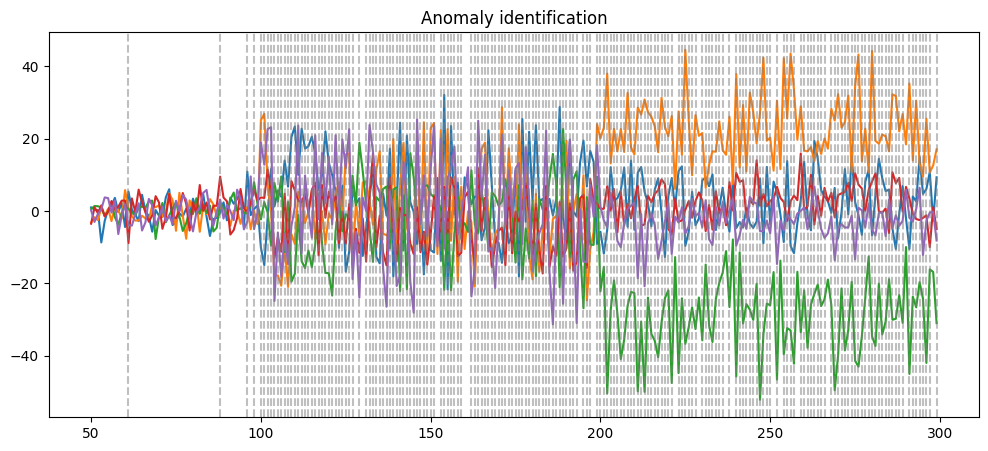

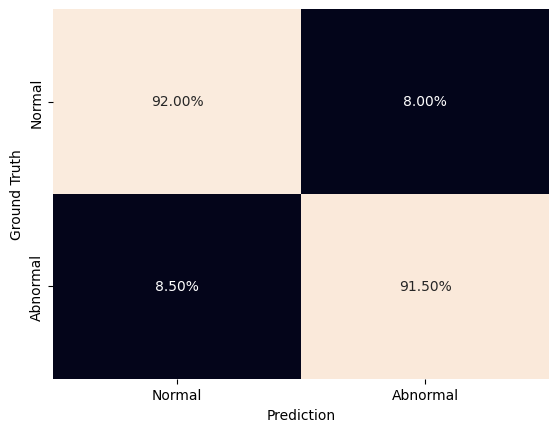

In [87]:
pca_3 = PCA(n_components=5, random_state=42)
pca_filt_train = pd.DataFrame(pca_3.fit_transform(lf_train), index=lf_train.index)
pca_filt_test = pd.DataFrame(pca_3.transform(lf_test), index=lf_test.index)
print(pca_filt_train.T.shape, pca_filt_test.T.shape)

distance_lf = compute_mahalanobis_distance(pca_filt_test.T, pca_filt_train.mean())
plot = distance_lf.plot(title = 'Distance Plot')
plot.axhline(distance_lf.median(), c='black',ls='--',label='Med' )
plot.axhline(distance_lf.quantile(0.25), c='r',ls='--', label='Q1')
plt.legend()
plt.show()

plot_anomalies(pca_filt_test.T, distance_lf, distance_lf.quantile(0.25)) # Q1 OF DISTACNE_LF AS A THRESHOLD

plot_confusion_mat(distance_lf, distance_lf.quantile(0.25), new_labels)

# PART 2: ICA

## Training data matrix **X**
- **U** - ICA output -- estimated source mat
- **W** - demixing mat
- **B** - feature mat -- $W^{-1}$
- **b_test** - test feat mat

In [731]:
normal_signals = df[:100]
X = normal_signals.sample(10, replace=False, random_state=1000)

In [732]:
ica_p2 = FastICA(random_state=42, max_iter=10000)
ica_p2.fit(X)

FastICA(max_iter=10000, random_state=42)

### create another set of labels for dataset
test dataset has total of 290 samples -- the rest of 90 normal signals, 100 of cyc, and 100 of upward

In [733]:
def labels(num_of_train_samples):
    labels = [0]*(100-num_of_train_samples) + [1]*200
    return labels


In [734]:
test_labels = labels(10)

In [736]:
X_test = df.drop(X.index)
W = ica_p2.components_
U = W[:,:10] @ X

U_pinv = np.linalg.pinv(U)
print(X.shape, W.shape,  X_test.shape, U.shape, U.T.shape, U_pinv.shape )

b_test = X_test @ U_pinv
print(b_test.shape) 


(10, 60) (10, 60) (290, 60) (10, 60) (60, 10) (60, 10)
(290, 10)


In [668]:
X_hat = np.dot(b_test, U)
X_hat = pd.DataFrame(X_hat, index=X_test.index)

In [674]:
def compute_euclidean_distance(y, y_hat):
    distance = np.sqrt(np.sum((y - y_hat)**2, axis=1))
    return distance

In [702]:
errors = compute_euclidean_distance(X_test, X_hat)
errors.shape

(290,)

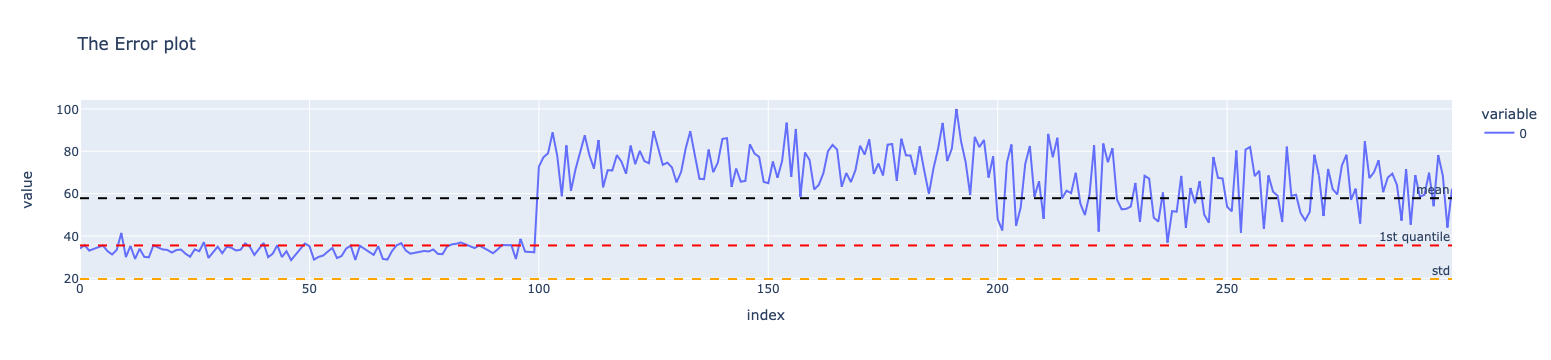

In [691]:
plotly_plot(errors).show()

#### By inspect from the graph above, will set a threshold = 40

anomaly sample:Index([  9, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       ...
       290, 291, 292, 293, 294, 295, 296, 297, 298, 299],
      dtype='int64', length=200)


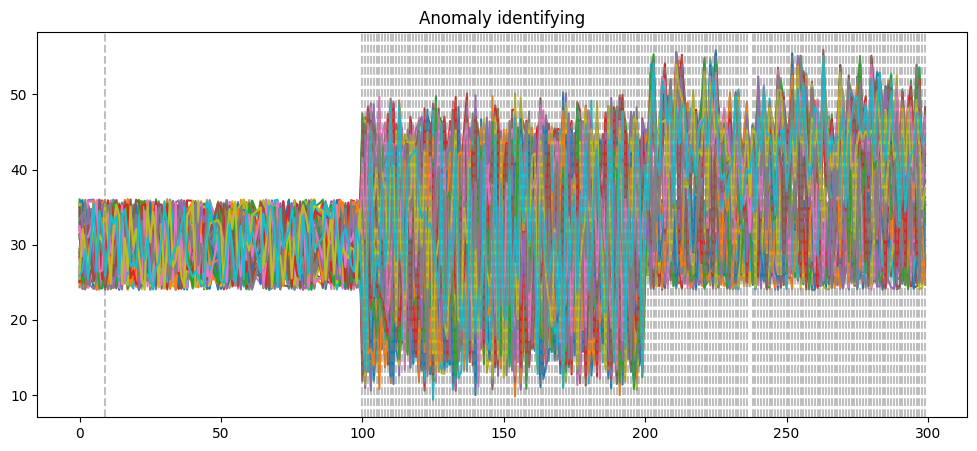

In [717]:
plot_anomalies(X_test.T, errors, 40)

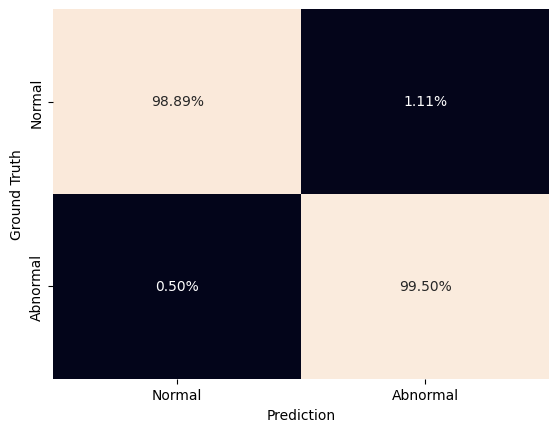

In [718]:
plot_confusion_mat(errors, 40, test_labels)

In [659]:
B =ica_p2.mixing_f
pd.DataFrame(B[:10])

0             1             2             3             4  \
0  3.864421e-16 -3.744364e-16  3.846074e-16 -3.699706e-16 -3.830610e-16   
1  8.606367e-16 -8.338990e-16  8.565506e-16 -8.239532e-16 -8.531065e-16   
2  1.008826e-15 -9.774849e-16  1.004037e-15 -9.658266e-16 -9.999997e-16   
3  5.135440e-16 -4.975896e-16  5.111059e-16 -4.916549e-16 -5.090508e-16   
4 -3.053855e-16  2.958980e-16 -3.039356e-16  2.923689e-16  3.027135e-16   
5  1.500658e-15 -1.454037e-15  1.493534e-15 -1.436695e-15 -1.487528e-15   
6 -4.894903e-16  4.742832e-16 -4.871663e-16  4.686265e-16  4.852075e-16   
7 -8.554570e-16  8.288803e-16 -8.513956e-16  8.189944e-16  8.479722e-16   
8 -7.158410e-16  6.936017e-16 -7.124424e-16  6.853293e-16  7.095777e-16   
9  1.781319e-15 -1.725978e-15  1.772862e-15 -1.705393e-15 -1.765733e-15   

              5             6             7             8             9  
0  3.801924e-16  3.860302e-16 -3.701143e-16 -3.826133e-16  3.881012e-16  
1  8.467180e-16  8.597192e-16 -8.242733e-16 -8.521096e-16  8.643316e-16  
2  9.925112e-16  1.007751e-15 -9.662018e-16 -9.988312e-16  1.013158e-15  
3  5.052388e-16  5.129966e-16 -4.918459e-16 -5.084559e-16  5.157488e-16  
4 -3.004467e-16 -3.050600e-16  2.924825e-16  3.023598e-16 -3.066966e-16  
5  1.476389e-15  1.499059e-15 -1.437253e-15 -1.485790e-15  1.507101e-15  
6 -4.815741e-16 -4.889685e-16  4.688085e-16  4.846405e-16 -4.915918e-16  
7 -8.416222e-16 -8.545451e-16  8.193125e-16  8.469813e-16 -8.591298e-16  
8 -7.042641e-16 -7.150779e-16  6.855955e-16  7.087486e-16 -7.189143e-16  
9  1.752511e-15  1.779420e-15 -1.706055e-15 -1.763670e-15  1.788967e-15

### Increasing number of train samples: 65

In [747]:
X_65 = normal_signals.sample(65, replace=False, random_state=1000)
X_test_65 = df.drop(X_65.index)
X_65.shape, X_test_65.shape

((65, 60), (235, 60))

In [779]:
ica_2 = FastICA(whiten_solver='svd', random_state=42, max_iter=1000)
ica_2.fit(X_65.T)

FastICA(max_iter=1000, random_state=42)

In [780]:
W_65 = ica_2.components_
pd.DataFrame(W_65)

0             1             2             3             4   \
0  -1.288348e+12 -6.440130e+10 -1.876841e+11 -9.679677e+11 -6.581444e+11   
1  -1.524726e+12 -7.621724e+10 -2.221192e+11 -1.145564e+12 -7.788965e+11   
2  -1.479123e+12 -7.393768e+10 -2.154759e+11 -1.111302e+12 -7.556007e+11   
3  -1.641399e+12 -8.204945e+10 -2.391160e+11 -1.233224e+12 -8.384984e+11   
4  -1.379142e+12 -6.893989e+10 -2.009109e+11 -1.036184e+12 -7.045262e+11   
5  -1.233524e+12 -6.166078e+10 -1.796975e+11 -9.267771e+11 -6.301379e+11   
6   1.419669e+12  7.096569e+10  2.068147e+11  1.066632e+12  7.252287e+11   
7   1.858802e+12  9.291686e+10  2.707868e+11  1.396564e+12  9.495571e+11   
8   1.485609e+12  7.426187e+10  2.164207e+11  1.116175e+12  7.589137e+11   
9   1.612655e+12  8.061260e+10  2.349286e+11  1.211628e+12  8.238146e+11   
10  1.709893e+12  8.547328e+10  2.490940e+11  1.284685e+12  8.734880e+11   
11 -1.727761e+12 -8.636648e+10 -2.516971e+11 -1.298110e+12 -8.826160e+11   
12 -1.685727e+12 -8.426528e+10 -2.455736e+11 -1.266528e+12 -8.611429e+11   
13  1.542380e+12  7.709971e+10  2.246910e+11  1.158828e+12  7.879148e+11   
14  1.364215e+12  6.819371e+10  1.987363e+11  1.024969e+12  6.969006e+11   
15  1.534959e+12  7.672877e+10  2.236100e+11  1.153253e+12  7.841241e+11   
16  1.445589e+12  7.226137e+10  2.105907e+11  1.086107e+12  7.384698e+11   
17 -1.534903e+12 -7.672595e+10 -2.236017e+11 -1.153210e+12 -7.840953e+11   
18 -1.318782e+12 -6.592261e+10 -1.921177e+11 -9.908334e+11 -6.736913e+11   
19 -1.562981e+12 -7.812950e+10 -2.276921e+11 -1.174306e+12 -7.984387e+11   
20 -1.320124e+12 -6.598969e+10 -1.923132e+11 -9.918417e+11 -6.743769e+11   
21 -1.728956e+12 -8.642622e+10 -2.518712e+11 -1.299008e+12 -8.832265e+11   
22  1.483475e+12  7.415520e+10  2.161098e+11  1.114571e+12  7.578237e+11   
23 -1.405755e+12 -7.027021e+10 -2.047878e+11 -1.056179e+12 -7.181213e+11   
24  1.346234e+12  6.729489e+10  1.961169e+11  1.011459e+12  6.877153e+11   
25  1.574917e+12  7.872618e+10  2.294310e+11  1.183274e+12  8.045365e+11   
26  1.422125e+12  7.108850e+10  2.071726e+11  1.068478e+12  7.264837e+11   
27 -1.354016e+12 -6.768388e+10 -1.972505e+11 -1.017306e+12 -6.916905e+11   
28  1.489791e+12  7.447094e+10  2.170300e+11  1.119317e+12  7.610503e+11   
29 -1.323407e+12 -6.615383e+10 -1.927915e+11 -9.943087e+11 -6.760542e+11   
30 -1.366231e+12 -6.829446e+10 -1.990300e+11 -1.026483e+12 -6.979303e+11   
31  1.193670e+12  5.966859e+10  1.738916e+11  8.968340e+11  6.097788e+11   
32 -1.530653e+12 -7.651353e+10 -2.229827e+11 -1.150018e+12 -7.819245e+11   
33  1.410548e+12  7.050976e+10  2.054860e+11  1.059779e+12  7.205694e+11   
34  1.517341e+12  7.584810e+10  2.210434e+11  1.140016e+12  7.751241e+11   
35 -1.201758e+12 -6.007289e+10 -1.750699e+11 -9.029107e+11 -6.139105e+11   
36  1.471873e+12  7.357526e+10  2.144197e+11  1.105855e+12  7.518970e+11   
37 -1.255307e+12 -6.274968e+10 -1.828708e+11 -9.431435e+11 -6.412658e+11   
38 -1.415684e+12 -7.076649e+10 -2.062342e+11 -1.063638e+12 -7.231930e+11   
39 -1.667976e+12 -8.337796e+10 -2.429877e+11 -1.253192e+12 -8.520750e+11   
40  1.228116e+12  6.139047e+10  1.789097e+11  9.227142e+11  6.273754e+11   
41 -1.294035e+12 -6.468559e+10 -1.885126e+11 -9.722407e+11 -6.610497e+11   
42  1.474670e+12  7.371510e+10  2.148273e+11  1.107956e+12  7.533261e+11   
43 -1.527835e+12 -7.637264e+10 -2.225721e+11 -1.147900e+12 -7.804846e+11   
44 -1.422141e+12 -7.108929e+10 -2.071749e+11 -1.068490e+12 -7.264919e+11   
45 -1.432194e+12 -7.159180e+10 -2.086393e+11 -1.076043e+12 -7.316272e+11   
46 -1.639793e+12 -8.196917e+10 -2.388820e+11 -1.232017e+12 -8.376780e+11   
47 -1.383743e+12 -6.916985e+10 -2.015811e+11 -1.039640e+12 -7.068763e+11   
48 -1.573354e+12 -7.864804e+10 -2.292033e+11 -1.182100e+12 -8.037379e+11   
49 -1.568727e+12 -7.841673e+10 -2.285292e+11 -1.178623e+12 -8.013741e+11   
50 -1.517715e+12 -7.586680e+10 -2.210979e+11 -1.140297e+12 -7.753152e+11   
51 -1.528933e+12 -7.642757e+10 -2.227322e+11 -1.148726e+12 -7.

### USING SMOOTH DATA

In [770]:
lf_X = low_filt_df[:100].sample(10, random_state=42)
lf_X_test = low_filt_df.drop(lf_X.index)
lf_X_test.shape, lf_X.shape

((290, 60), (10, 60))

In [ ]:
lf_ica = FastICA()